In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import sklearn.metrics
from sklearn.metrics import roc_auc_score



import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('revo_ds_test_task.csv')

In [3]:
data.head()

,loanKey,rep_loan_date,first_loan,dpd_5_cnt,dpd_15_cnt,dpd_30_cnt,first_overdue_date,close_loans_cnt,federal_district_nm,TraderKey,...,payment_type_2,payment_type_3,payment_type_4,payment_type_5,past_billings_cnt,score_1,score_2,age,gender,bad_flag
0,708382,2016-10-06,2015-11-13,NaN,NaN,NaN,NaN,3.0,region_6,6,...,10,0,0,0,10.0,NaN,NaN,21.0,False,0
1,406305,2016-03-26,2015-09-28,1.0,0.0,0.0,2016-01-30,0.0,region_6,6,...,6,0,0,0,5.0,NaN,NaN,20.0,False,0
2,779736,2016-10-30,2015-12-21,NaN,NaN,NaN,NaN,2.0,region_1,6,...,0,5,0,0,5.0,NaN,NaN,19.0,False,0
3,556376,2016-06-29,2015-06-30,NaN,NaN,NaN,NaN,1.0,region_6,14,...,4,0,0,0,6.0,NaN,NaN,21.0,False,0
4,266968,2015-12-01,2015-08-03,NaN,NaN,NaN,NaN,0.0,region_5,22,...,0,0,0,0,3.0,NaN,NaN,33.0,False,0


In [4]:
data.dtypes

loanKey                  int64
rep_loan_date           object
first_loan              object
dpd_5_cnt              float64
dpd_15_cnt             float64
dpd_30_cnt             float64
first_overdue_date      object
close_loans_cnt        float64
federal_district_nm     object
TraderKey                int64
payment_type_0           int64
payment_type_1           int64
payment_type_2           int64
payment_type_3           int64
payment_type_4           int64
payment_type_5           int64
past_billings_cnt      float64
score_1                float64
score_2                float64
age                    float64
gender                    bool
bad_flag                 int64
dtype: object

In [5]:
data.close_loans_cnt.fillna(data.close_loans_cnt.mean(), inplace=True)
data.past_billings_cnt.fillna(0, inplace=True)
# Count the number of NaN values in each column
print(data.isnull().sum())

loanKey                   0
rep_loan_date             0
first_loan                0
dpd_5_cnt              3482
dpd_15_cnt             3482
dpd_30_cnt             3482
first_overdue_date     3482
close_loans_cnt           0
federal_district_nm      11
TraderKey                 0
payment_type_0            0
payment_type_1            0
payment_type_2            0
payment_type_3            0
payment_type_4            0
payment_type_5            0
past_billings_cnt         0
score_1                 650
score_2                3918
age                       0
gender                    0
bad_flag                  0
dtype: int64


In [6]:
data["rep_loan_date"] = pd.to_datetime(data["rep_loan_date"])
data["first_loan"] = pd.to_datetime(data["first_loan"])
data["first_overdue_date"] = pd.to_datetime(data["first_overdue_date"])
data["TraderKey"] = pd.to_numeric(data["TraderKey"], downcast='signed')
data["past_billings_cnt"] = data["past_billings_cnt"].astype(int)
data["age"] = data["age"].astype(int)
data['federal_district_nm'] = data['federal_district_nm'].astype('category')

In [7]:
data['first_loan_year']= data['first_loan'].apply(lambda x: x.year)
data['first_loan_month'] = data['first_loan'].apply(lambda x: x.month)
data['first_loan_day'] = data['first_loan'].apply(lambda x: x.day)

data['rep_loan_date_year']= data['rep_loan_date'].apply(lambda x: x.year)
data['rep_loan_date_month'] = data['rep_loan_date'].apply(lambda x: x.month)
data['rep_loan_date_day'] = data['rep_loan_date'].apply(lambda x: x.day)

data['first_overdue_year']= data['first_overdue_date'].apply(lambda x: x.year)
data['first_overdue_month'] = data['first_overdue_date'].apply(lambda x: x.month)
data['first_overdue_day'] = data['first_overdue_date'].apply(lambda x: x.day)

In [8]:
# Cleaning
list_del =['loanKey']
for i in data.columns:
    if data[i].isnull().sum() == data.shape[0]: # or len(data[i].unique()) < 3
        list_del.append(i)
data.drop(list_del, axis=1, inplace=True)
print('The following columns were deleted:', list_del)

The following columns were deleted: ['loanKey']


In [9]:
from datetime import datetime
data['Difference'] = (data['first_overdue_date'] - data['first_loan']).dt.days
data['Recurrence'] = (data['rep_loan_date'] - data['first_loan']).dt.days

In [10]:
# See the missing values
print(data.isnull().sum())

rep_loan_date             0
first_loan                0
dpd_5_cnt              3482
dpd_15_cnt             3482
dpd_30_cnt             3482
first_overdue_date        0
close_loans_cnt           0
federal_district_nm      11
TraderKey                 0
payment_type_0            0
payment_type_1            0
payment_type_2            0
payment_type_3            0
payment_type_4            0
payment_type_5            0
past_billings_cnt         0
score_1                 650
score_2                3918
age                       0
gender                    0
bad_flag                  0
first_loan_year           0
first_loan_month          0
first_loan_day            0
rep_loan_date_year        0
rep_loan_date_month       0
rep_loan_date_day         0
first_overdue_year     3482
first_overdue_month    3482
first_overdue_day      3482
Difference             3482
Recurrence                0
dtype: int64


In [11]:
data = data.dropna(how='all')    #to drop if all values in the row are nan
data.shape

(4157, 32)

In [12]:
def create_dummy(column):
    global data
    dummy_ranks = pd.get_dummies(data[column], prefix=column, dtype=bool)
    # Create dummy variables for the regression
    cols_to_keep = list(data.columns.values)
    data = data[cols_to_keep].join(dummy_ranks.ix[:, column:])
    data.drop(column, axis=1, inplace=True)

In [13]:
create_dummy("federal_district_nm")
create_dummy("dpd_5_cnt")
create_dummy("dpd_15_cnt")
create_dummy("dpd_30_cnt")

In [14]:
data["Difference"].fillna(0, inplace=True)
data["first_overdue_year"].fillna(0, inplace=True)
data["first_overdue_month"].fillna(0, inplace=True)
data["first_overdue_day"].fillna(0, inplace=True)

# Balance the dataset

In [15]:
from sklearn.utils import resample
data['bad_flag'].value_counts()

0    3740
1     417
Name: bad_flag, dtype: int64

In [16]:
# Separate majority and minority classes
df_majority = data[data.bad_flag==0]
df_minority = data[data.bad_flag==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=3740,    # to match majority class
                                 random_state=123) # reproducible results

In [17]:
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Display new class counts
df_upsampled.bad_flag.value_counts()

1    3740
0    3740
Name: bad_flag, dtype: int64

In [18]:
from sklearn.utils import shuffle
df_upsampled = shuffle(df_upsampled, random_state=0)

# Splitting the data

In [19]:
columns = df_upsampled.columns.tolist()
columns = [c for c in columns if c not in ["rep_loan_date", 'first_loan', "first_overdue_date", 
                                           "bad_flag", "score_1", "score_2", "past_billings_cnt"]]

In [20]:
y = df_upsampled.bad_flag
X_train, X_test, y_train, y_test = train_test_split(df_upsampled[columns], y, test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5984, 47) (5984,)
(1496, 47) (1496,)


# Logistic regression

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
model1 = LogisticRegression()
model1.fit(X_train, y_train)
y_pred1 = model1.predict(X_test)
print("Accuracy for logistic regression: %.2f" % (model1.score(X_test, y_test) * 100))

Accuracy for logistic regression: 67.45


In [22]:
# evaluate the model using 10-fold cross-validation
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
results = model_selection.cross_val_score(model1, X_train, y_train, cv=10, scoring='accuracy')
print("10-fold cross validation average accuracy: %.3f" % (results.mean()* 100))

10-fold cross validation average accuracy: 67.680


In [23]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred1)
print(confusion_matrix)

[[502 260]
 [227 507]]


In [24]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred1))

             precision    recall  f1-score   support

          0       0.69      0.66      0.67       762
          1       0.66      0.69      0.68       734

avg / total       0.68      0.67      0.67      1496



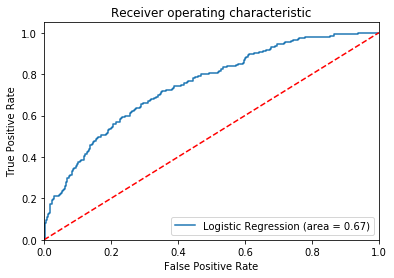

In [25]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, model1.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, model1.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

# Random forest

In [26]:
from sklearn.ensemble import RandomForestClassifier

model2 = RandomForestClassifier(n_estimators = 100)
model2 = model2.fit(X_train, y_train)
y_pred2 = model2.predict(X_test)
print("Accuracy for random forest: %.2f" % (model2.score(X_test, y_test) * 100))

Accuracy for random forest: 98.80


In [27]:
# evaluate the model using 10-fold cross-validation
results = model_selection.cross_val_score(model2, X_train, y_train, cv=10, scoring='accuracy')
print("10-fold cross validation average accuracy: %.3f" % (results.mean()* 100))

10-fold cross validation average accuracy: 98.479


In [28]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred2)
print(confusion_matrix)

[[744  18]
 [  0 734]]


In [29]:
print(classification_report(y_test, y_pred1))

             precision    recall  f1-score   support

          0       0.69      0.66      0.67       762
          1       0.66      0.69      0.68       734

avg / total       0.68      0.67      0.67      1496



In [30]:
list(zip(X_train, model2.feature_importances_))

[('close_loans_cnt', 0.048615717199515317),
 ('TraderKey', 0.049564428444146665),
 ('payment_type_0', 0.0019650063782175871),
 ('payment_type_1', 0.020995279074415844),
 ('payment_type_2', 0.059247080213672476),
 ('payment_type_3', 0.031988216145023694),
 ('payment_type_4', 0.0015512146045797623),
 ('payment_type_5', 0.0),
 ('age', 0.11362825480975122),
 ('gender', 0.015496957464726367),
 ('first_loan_year', 0.012128382307684824),
 ('first_loan_month', 0.064183853253590301),
 ('first_loan_day', 0.08947697989643083),
 ('rep_loan_date_year', 0.01678026224076665),
 ('rep_loan_date_month', 0.061381042256457068),
 ('rep_loan_date_day', 0.087413733936029275),
 ('first_overdue_year', 0.009316715654163343),
 ('first_overdue_month', 0.022217689910850283),
 ('first_overdue_day', 0.016371773625675552),
 ('Difference', 0.026898282588421373),
 ('Recurrence', 0.14279000517952586),
 ('federal_district_nm_region_0', 0.008114796913167726),
 ('federal_district_nm_region_1', 0.0074712391970870491),
 ('fe

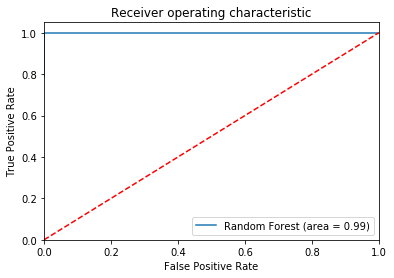

In [31]:
logit_roc_auc2 = roc_auc_score(y_test, model2.predict(X_test))
fpr2, tpr2, thresholds2 = roc_curve(y_test, model2.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr2, tpr2, label='Random Forest (area = %0.2f)' % logit_roc_auc2)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Random_Forest_ROC')
plt.show()

# XGboost Classification

In [32]:
model3 = xgboost.XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

model3.fit(X_train, y_train)
y_pred3 = model3.predict(X_test)
print("Accuracy for XGBoost: %.2f" % (model3.score(X_test, y_test) * 100))

Accuracy for XGBoost: 97.06


In [33]:
# evaluate the model using 10-fold cross-validation
results = model_selection.cross_val_score(model3, X_train, y_train, cv=10, scoring='accuracy')
print("10-fold cross validation average accuracy: %.3f" % (results.mean()* 100))

10-fold cross validation average accuracy: 96.708


In [34]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred3)
print(confusion_matrix)

[[718  44]
 [  0 734]]


In [35]:
print(classification_report(y_test, y_pred3))

             precision    recall  f1-score   support

          0       1.00      0.94      0.97       762
          1       0.94      1.00      0.97       734

avg / total       0.97      0.97      0.97      1496



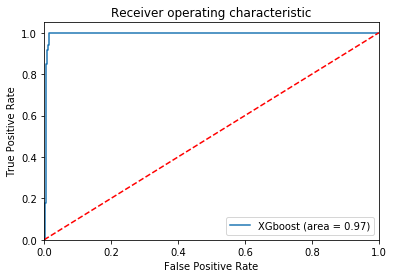

In [36]:
logit_roc_auc3 = roc_auc_score(y_test, model3.predict(X_test))
fpr3, tpr3, thresholds3 = roc_curve(y_test, model3.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr3, tpr3, label='XGboost (area = %0.2f)' % logit_roc_auc3)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('XGboost_ROC')
plt.show()

# SVM classifier

In [ ]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
# Set the parameters to try
# Gaussian radial basis function kernel
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    model4 = svm.SVC()
    model4 = GridSearchCV(model4, tuned_parameters, cv=5, scoring='%s_macro' % score)
    model4.fit(X_train, y_train)

    print("\nBest parameters set found on development set: %r" % (model4.best_params_))
    print("Grid scores on development set:\n")

    means = model4.cv_results_['mean_test_score']
    stds = model4.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, model4.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print("\n Detailed classification report:\n")
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.\n")
    
    y_pred4 = model4.predict(X_test)
    print(classification_report(y_test, y_pred4))
    print()

In [38]:
from sklearn import svm
#Training with the best parameters: {'C': 1, 'kernel': 'linear'}
model4 = svm.SVC(C = 1000, kernel='rbf', gamma = 0.001, probability=True)
model4.fit(X_train, y_train)
y_pred4 = model4.predict(X_test)
print("Accuracy for support vector classifier: %.2f" % (model4.score(X_test, y_test) * 100))

Accuracy for support vector classifier: 93.52


In [39]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred4)
print(confusion_matrix)

[[669  93]
 [  4 730]]


In [40]:
print(classification_report(y_test, y_pred4))

             precision    recall  f1-score   support

          0       0.99      0.88      0.93       762
          1       0.89      0.99      0.94       734

avg / total       0.94      0.94      0.94      1496



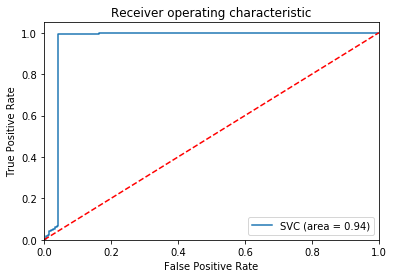

In [41]:
logit_roc_auc4 = roc_auc_score(y_test, model4.predict(X_test))
fpr4, tpr4, thresholds4 = roc_curve(y_test, model4.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr4, tpr4, label='SVC (area = %0.2f)' % logit_roc_auc4)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc = "lower right")
plt.savefig('SVC_ROC')
plt.show()

# Summary

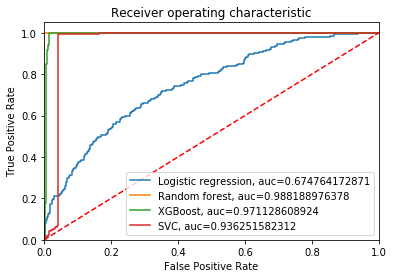

In [42]:
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

plt.figure(0).clf()

pred = np.random.rand(1000)
label = np.random.randint(2, size=1000)
fpr1, tpr1, thresholds1 = roc_curve(y_test, model1.predict_proba(X_test)[:,1])
auc1 = roc_auc_score(y_test, model1.predict(X_test))
plt.plot(fpr1,tpr1,label="Logistic regression, auc="+str(auc1))

pred = np.random.rand(1000)
label = np.random.randint(2, size=1000)
fpr2, tpr2, thresholds2 = roc_curve(y_test, model2.predict_proba(X_test)[:,1])
auc2 = roc_auc_score(y_test, model2.predict(X_test))
plt.plot(fpr2,tpr2,label="Random forest, auc="+str(auc2))


pred = np.random.rand(1000)
label = np.random.randint(2, size=1000)
fpr3, tpr3, thresholds3 = roc_curve(y_test, model3.predict_proba(X_test)[:,1])
auc3 = roc_auc_score(y_test, model3.predict(X_test))
plt.plot(fpr3,tpr3,label="XGBoost, auc="+str(auc3))


pred = np.random.rand(1000)
label = np.random.randint(2, size=1000)
fpr4, tpr4, thresholds4 = roc_curve(y_test, model4.predict_proba(X_test)[:,1])
auc4 = roc_auc_score(y_test, model4.predict(X_test))
plt.plot(fpr4,tpr4,label="SVC, auc="+str(auc4))


plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Total_ROC')

plt.legend(loc=0)

In [43]:
# define a function that accepts a threshold and prints sensitivity and specificity
def evaluate_threshold(threshold2):
    print('Sensitivity:', tpr2[thresholds2 > threshold2][-1])
    print('Specificity:', 1 - fpr2[thresholds2 > threshold2][-1])

In [44]:
evaluate_threshold(0.8)
# Sensitivity - true positive rate - defaults correctly identified
# Specificity - false positive rate - good loans correctly identified

Sensitivity: 0.99727520436
Specificity: 1.0


In [45]:
evaluate_threshold(0.33)
# Sensitivity - true positive rate - defaults correctly identified
# Specificity - false positive rate - good loans correctly identified

Sensitivity: 1.0
Specificity: 0.89501312336
